# Running analysis for scIHPF 

In [1]:
## Import scripts for the dimension reduction methods 
import IHPF
import INMF 
import schpf
from sklearn.decomposition import PCA

In [2]:
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

In [3]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [4]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max', 'INMF_0.1_kmeans_normalised', 'INMF_0.1_max', 'INMF_0.5_kmeans_normalised', 'INMF_0.5_max', 'INMF_1.0_kmeans_normalised', 'INMF_1.0_max', 'INMF_10.0_kmeans_normalised', 'INMF_10.0_max', 'INMF_1e-05_kmeans_normalised', 'INMF_1e-05_max', 'INMF_0.0001_kmeans_normalised', 'INMF_0.0001_max', 'INMF_0.001_kmeans_normalised', 'INMF_0.001_max', 'INMF_0.01_kmeans_normalised', 'INMF_0.01_max', 'IHPF_0.1_kmeans_normalised', 'IHPF_0.1_max', 'IHPF_0.5_kmeans_normalised', 'IHPF_0.5_max', 'IHPF_1.0_kmeans_normalised', 'IHPF_1.0_max', 'IHPF_10.0_kmeans_normalised', 'IHPF_10.0_max', 'IHPF_1e-05_kmeans_normalised', 'IHPF_1e-05_max', 'IHPF_0.0001_kmeans_normalised', 'IHPF_0.0001_max', 'IHPF_0.001_kmeans_normalised', 'IHPF_0.001_max', 'IHPF_0.01_kmeans_normalised', 'IHPF_0.01_max'
   

## IHPF 

In [ ]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = IHPF.scIHPF(no_cell_types,max_iter=500)
    model.fit(Xlist,dataset_ratio=0.1)
    adata.obsm['IHPF'] = np.concatenate(model.cell_scores(),axis=0)
    adata.varm['IHPF'] = model.shared_gene_scores()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF']))
    adata.obs['IHPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['IHPF_max'] = np.argmax(adata.obsm['IHPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))
    

## INMF 

In [ ]:
from INMF import INMF

In [ ]:
class scINMF:
    def __init__(self, k, alpha=1, **kwargs):
        np.random.seed(0)
        self.n_components = k
        self.method = INMF(
            n_components=self.n_components, solver="mu", alpha=alpha, **kwargs
        )

    def fit(self, X):
        self.data = X
        (
            self.cell_scores,
            self.shared_gene_scores,
            self.dataset_gene_scores,
        ) = self.method.fit_transform(self.data)


In [ ]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scINMF(no_cell_types,alpha=1,max_iter=500)
    model.fit(Xlist)
    adata.obsm['INMF'] = np.concatenate(model.cell_scores,axis=0)
    adata.varm['INMF'] = model.shared_gene_scores.transpose()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF']))
    adata.obs['INMF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['INMF_max'] = np.argmax(adata.obsm['INMF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

## HPF

In [ ]:
from schpf import scHPF
from scipy.sparse import vstack

In [ ]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scHPF(no_cell_types,max_iter=500)
    model.fit(vstack(Xlist))
    adata.obsm['HPF'] = model.cell_score()
    adata.varm['HPF'] = model.gene_score()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['HPF']))
    adata.obs['HPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['HPF_max'] = np.argmax(adata.obsm['HPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

## PCA

In [ ]:
class scPCA:
    def __init__(self, k):
        from sklearn.decomposition import TruncatedSVD

        np.random.seed(0)
        self.n_components = k
        self.method = TruncatedSVD(n_components=self.n_components)

    def fit(self, X):
        self.data = X
        self.method.fit(self.data)
        self.cell_score = self.method.transform(self.data)
        self.gene_score = self.method.components_.transpose()

In [ ]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scPCA(no_cell_types)
    model.fit(vstack(Xlist))
    adata.obsm['PCA'] = model.cell_score
    adata.varm['PCA'] = model.gene_score
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['PCA']))
    adata.obs['PCA_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['PCA_max'] = np.argmax(adata.obsm['PCA'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [ ]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

## Clustering performance

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score
from sklearn import preprocessing

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc',]

In [ ]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        batch[method] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_kmeans_normalised'.format(method)])
        actual[method] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_kmeans_normalised'.format(method)])
    batch['actual'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    actual['batch'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [ ]:
np.round(pd.DataFrame(actualAMI),3)

In [ ]:
np.round(pd.DataFrame(batchAMI),3)

In [ ]:
batchputriy = dict()
actualputriy = dict()

for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        le = preprocessing.LabelEncoder()
        batchlabel = le.fit_transform(adata.obs[batch_labels])
        le = preprocessing.LabelEncoder()
        actuallabel = le.fit_transform(adata.obs[cell_labels])
        no_cell_types = len(adata.obs[cell_labels].unique())
        batch[method] = np.sum(np.max(confusion_matrix(batchlabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
        actual[method] = np.sum(np.max(confusion_matrix(actuallabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
    actual['batch'] =  np.sum(np.max(confusion_matrix(actuallabel,batchlabel),axis=1)) / len(adata.obs[cell_labels])
    batchputriy[dataset] = batch
    actualputriy[dataset] = actual

In [ ]:
np.round(pd.DataFrame(actualputriy),3)

In [ ]:
SC = dict()
for dataset in datasets:
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['INMF','IHPF','HPF','PCA']:
        batch[method] = silhouette_score(adata.obsm['{}'.format(method)],adata.obs['{}_kmeans_normalised'.format(method)],)
    SC[dataset] = batch

In [ ]:
np.round(pd.DataFrame(SC),3)

## Heatmap of cluster labels with actual labels

In [ ]:
import seaborn as sns
for dataset in ['10Xmouse',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

In [ ]:
for dataset in ['10Xpbmc',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

In [ ]:
for dataset in ['humanpancreas',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

## TSNE 

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc',]

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        adata.obsm['{}_TSNE'.format(method)] = TSNE(n_jobs=60).fit_transform(normalize(adata.obsm[method]))
    adata.write('../Data/{}.h5ad'.format(dataset))

## TSNE plot 

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of IHPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'IHPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[cell_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_IHPF_cell_v2.pdf'.format(),format='pdf')

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of IHPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc',]
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'IHPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[batch_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_IHPF_batch_v2.pdf'.format(),format='pdf')

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of HPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'HPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[cell_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_HPF_cell_v2.pdf'.format(),format='pdf')

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of HPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'HPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[batch_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_HPF_batch_v2.pdf'.format(),format='pdf')

## Block structure 

In [ ]:
Plot_no = len(datasets)
f, axes = plt.subplots(Plot_no, 3, figsize=(36, 21))
f.suptitle('Heatmap of latent factors for different data integration methods'.format())

j = 0 
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    # sort the cell score by cell types
    cell_score_df = pd.DataFrame(adata.obsm['PCA'])
    cell_score_df['labels'] = adata.obs[cell_labels].values
    cell_score_df = cell_score_df.set_index(['labels']).sort_index()   
    cell_score_df2 = pd.DataFrame(adata.obsm['INMF'])
    cell_score_df2['labels'] = adata.obs[cell_labels].values
    cell_score_df2 = cell_score_df2.set_index(['labels']).sort_index()
    cell_score_df3 = pd.DataFrame(adata.obsm['IHPF'])
    cell_score_df3['labels'] = adata.obs[cell_labels].values
    cell_score_df3 = cell_score_df3.set_index(['labels']).sort_index()
    
    # Plot heatmap 
    sb.heatmap(cell_score_df, ax=axes[j,0], ).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of PCA {}'.format(dataset))
    sb.heatmap(cell_score_df2, ax=axes[j,1],).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of integrative NMF {}'.format(dataset))
    sb.heatmap(cell_score_df3, ax=axes[j,2],).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of integrative HPF {}'.format(dataset))
    j += 1
    
f.savefig('../Result/Dataset_techs_cellmaps_all_v2.pdf'.format(),format='pdf')

In [ ]:
# Gene Scores block structure 

from sklearn.cluster import AgglomerativeClustering, SpectralCoclustering

In [ ]:
Plot_no = len(datasets)
f, axes = plt.subplots(Plot_no, 3, figsize=(36, 21))
f.suptitle('Heatmap of latent factors for different data integration methods'.format())

j = 0 
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    # PCA gene scores 
    data= pd.DataFrame(adata.varm['PCA'])
    n_factors = adata.varm['PCA'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 0], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of PCA {}'.format(dataset))
    # INMF gene scores 
    data= pd.DataFrame(adata.varm['INMF'])
    n_factors = adata.varm['INMF'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 1], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of integrative NMF {}'.format(dataset))    
    # IHPF gene scores 
    data= pd.DataFrame(adata.varm['IHPF'])
    n_factors = adata.varm['IHPF'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 2], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of integrative HPF {}'.format(dataset))    
    
    j += 1
    
f.savefig('../Result/Dataset_techs_genemaps_all_v2.pdf'.format(),format='pdf')

## Hyper-parameter search

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [ ]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby(batch_labels):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = scINMF(no_cell_types,alpha=1/l,max_iter=500)
        model.fit(Xlist)
        adata.obsm['INMF_{}'.format(l)] = np.concatenate(model.cell_scores,axis=0)
        adata.varm['INMF_{}'.format(l)] = model.shared_gene_scores.transpose()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF_{}'.format(l)]))
        adata.obs['INMF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['INMF_{}_max'.format(l)] = np.argmax(adata.obsm['INMF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [ ]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'      
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby(batch_labels):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = IHPF.scIHPF(no_cell_types,max_iter=500)
        model.fit(Xlist,dataset_ratio=l)
        adata.obsm['IHPF_{}'.format(l)] = np.concatenate(model.cell_scores(),axis=0)
        adata.varm['IHPF_{}'.format(l)] = model.shared_gene_scores()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF_{}'.format(l)]))
        adata.obs['IHPF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['IHPF_{}_max'.format(l)] = np.argmax(adata.obsm['IHPF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [ ]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [ ]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'        
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for method in ['IHPF','INMF']:
        for l in hyper_parameter_space:
            batch[(method,l)] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
            actual[(method,l)] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [ ]:
np.round(pd.DataFrame(actualAMI),3)

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(28, 7)
fig.suptitle('AMI of integrative HPF and integrative NMF with different noise ratios')
AMI = pd.DataFrame(actualAMI).reset_index()
AMI.columns = ['Method','Noise'] + datasets
for dataset_no in range(0,3):  
    # reshape multi index df into single index 
    df = AMI.pivot(index="Noise", columns="Method")[datasets[dataset_no]]
    df.plot(ax=axs[dataset_no], logx=True)
    axs[dataset_no].set(xlabel='Noise ratio', ylabel='AMI',title='Scenario {}'.format(datasets[dataset_no]))
plt.savefig('../Result/Grid_Search_AMI_v2.pdf'.format(datasets[dataset_no]),format='pdf')

### Differential expressed genes

In [16]:
datasets = ['humanpancreas','10Xpbmc','10Xmouse',]

In [53]:
datasets = ['10Xmouse',]

In [54]:
IHPF_top_genes = dict()

for dataset in datasets:
    IHPF_top_genes[dataset] = list()
    batch_labels = 'batch'
    cell_labels = 'actual'  
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    # IHPF gene scores 
    data= pd.DataFrame(adata.varm['IHPF'])
    data.index = adata.var.index
    mean = data.mean(axis=1)
    for i in range(0,data.shape[1]):
        ratio = data[i]
        IHPF_top_genes[dataset].append(ratio.sort_values(ascending=False)[:50].index)

In [55]:
## Select top ranking genes in each latent factor 

In [56]:
IHPFgenes = list()
for y in IHPF_top_genes[dataset]:
    IHPFgenes.extend(y)
IHPFgenes = set(IHPFgenes)

In [57]:
## Use logstic regression to rank genes 
logadata = sc.pp.log1p(adata,copy=True)
sc.tl.rank_genes_groups(logadata,groupby='actual')

In [58]:
logadata.uns['rank_genes_groups']['names'][:20]

rec.array([('LINC00636', 'C1orf167'), ('RP11-384K6.6', 'NEXN'),
           ('RP11-558F24.4', 'SEPT10'), ('MRPL3', 'RP3-436N22.3'),
           ('PRAMEF26', 'RP11-252P19.1'), ('AC097662.2', 'MCF2L2'),
           ('HHIP-AS1', 'AL645728.1'), ('DLG1-AS1', 'CTD-2281M20.1'),
           ('USP17L15', 'VGLL4'), ('FAM134B', 'FUBP1'),
           ('LINC00883', 'CDK5'), ('FEZF1-AS1', 'SORBS2'),
           ('TMEM168', 'AC017060.1'), ('PPIG', 'RP1-170O19.17'),
           ('PLXNA4', 'FBXL2'), ('EPRS', 'RAB42'), ('RYBP', 'FAM43B'),
           ('TRIM43', 'UQCRQ'), ('RP11-508O18.1', 'EIF4H'),
           ('CLCNKA', 'PRPH2')],
          dtype=[('293t', 'O'), ('jurkat', 'O')])

In [59]:
loggenes = list()
for x in logadata.uns['rank_genes_groups']['names'][:50]:
    for y in x:
        loggenes.append(y)
loggenes = set(loggenes)

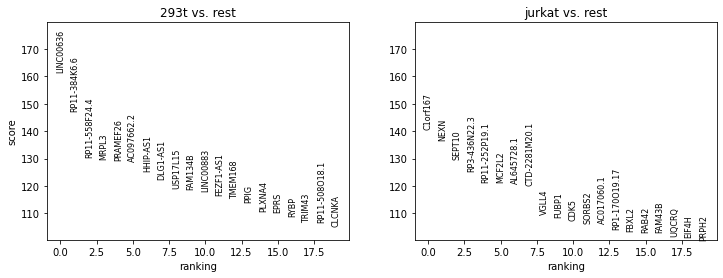

In [60]:
sc.pl.rank_genes_groups(logadata)

In [61]:
IHPFgenes.intersection(loggenes)

{'TNFAIP6', 'ZNF398'}

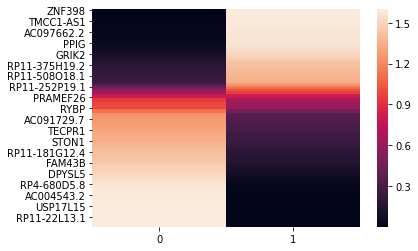

In [67]:
import seaborn as sns
sns.heatmap(data.loc[loggenes,:].sort_values(0))